In [72]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from sklearn.metrics import f1_score, classification_report
from matplotlib import pyplot as plt

In [73]:
df = pd.read_csv(r'data\Student Depression Dataset.csv')
df

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,140685,Female,27.0,Surat,Student,5.0,0.0,5.75,5.0,0.0,5-6 hours,Unhealthy,Class 12,Yes,7.0,1.0,Yes,0
27897,140686,Male,27.0,Ludhiana,Student,2.0,0.0,9.40,3.0,0.0,Less than 5 hours,Healthy,MSc,No,0.0,3.0,Yes,0
27898,140689,Male,31.0,Faridabad,Student,3.0,0.0,6.61,4.0,0.0,5-6 hours,Unhealthy,MD,No,12.0,2.0,No,0
27899,140690,Female,18.0,Ludhiana,Student,5.0,0.0,6.88,2.0,0.0,Less than 5 hours,Healthy,Class 12,Yes,10.0,5.0,No,1


In [74]:
target_var = ['Depression']

# Категориальные переменные и их веса (влияние на депрессию)
categorical_values = {
    'Sleep Duration': 0.8,  # Увеличено влияние (недосып сильно коррелирует с депрессией)
    'Dietary Habits': 0.5   # Сбалансировано (диета имеет умеренное влияние)
}

# Числовые переменные (чем больше, тем лучше - прямые факторы)
numeric_values = {
    'Study Satisfaction': 0.6,  # Снижено (влияет, но не так сильно как сон)
    'Job Satisfaction': 0.7      # Оставлено высоким (удовлетворенность работой важна)
}

# Числовые переменные (чем меньше, тем лучше - факторы стресса)
numeric_values_inv = {
    'Academic Pressure': 0.7,    # Увеличено (академический стресс - ключевой фактор)
    'Work Pressure': 0.6,        # Оставлено значимым
    'Work/Study Hours': 0.5,     # Снижено (длительность менее важна, чем интенсивность)
    'Financial Stress': 0.8      # Увеличено (финансовый стресс - один из главных факторов)
}

# Максимальные значения для нормализации
numeric_values_max = df[numeric_values.keys()].max() * 1.2
numeric_values_inv_max = df[numeric_values_inv.keys()].max() * 1.2

# Фаззификация категориальных переменных (обновлённые значения)
sleep_duration_defuzz = {
    'Less than 5 hours': 0.9,  # Сильное влияние на депрессию
    '5-6 hours': 0.6,
    '7-8 hours': 0.3,          # Оптимальный диапазон
    'More than 8 hours': 0.5,   # Избыток сна тоже может быть вреден
    'Others': 0.5
}

dietary_habits_defuzz = {
    'Healthy': 0.3,     # Здоровая диета снижает риск
    'Unhealthy': 0.85,  # Неправильное питание сильно влияет
    'Moderate': 0.5,
    'Others': 0.5
}

categorical_values_defuzz = {
    'Sleep Duration': sleep_duration_defuzz,
    'Dietary Habits': dietary_habits_defuzz
}

# Собираем все независимые переменные
independent_vars = list(categorical_values.keys()) + list(numeric_values.keys()) + list(numeric_values_inv.keys())
independent_vars_weights = categorical_values | numeric_values | numeric_values_inv

In [75]:
df = df[
    independent_vars + target_var
    ]
df.loc[:, numeric_values.keys()] = df[numeric_values.keys()] / numeric_values_max
df.loc[:, numeric_values_inv.keys()] = 1 - df[numeric_values_inv.keys()] / numeric_values_inv_max

for col, mapping in categorical_values_defuzz.items():
    df.loc[:, col] = df[col].map(mapping)

df

,Sleep Duration,Dietary Habits,Study Satisfaction,Job Satisfaction,Academic Pressure,Work Pressure,Work/Study Hours,Financial Stress,Depression
0,0.6,0.3,0.333333,0.0,0.166667,1.0,0.791667,0.833333,1
1,0.6,0.5,0.833333,0.0,0.666667,1.0,0.791667,0.666667,0
2,0.9,0.3,0.833333,0.0,0.500000,1.0,0.375000,0.833333,0
3,0.3,0.5,0.333333,0.0,0.500000,1.0,0.722222,0.166667,1
4,0.6,0.5,0.500000,0.0,0.333333,1.0,0.930556,0.833333,0
...,...,...,...,...,...,...,...,...,...
27896,0.6,0.85,0.833333,0.0,0.166667,1.0,0.513889,0.833333,0
27897,0.9,0.3,0.500000,0.0,0.666667,1.0,1.000000,0.500000,0
27898,0.6,0.85,0.666667,0.0,0.500000,1.0,0.166667,0.666667,0
27899,0.9,0.3,0.333333,0.0,0.166667,1.0,0.305556,0.166667,1


In [76]:
a, b = zip(*independent_vars_weights.items())
b

(0.8, 0.5, 0.6, 0.7, 0.7, 0.6, 0.5, 0.8)

In [ ]:
def sugeno_integral(values, weights):
    """
    Вычисляет интеграл Сугено для заданных значений и весов.

    Параметры:
    - values: список значений функции (f(x1), f(x2), ..., f(xn))
    - weights: список мер (g({x1}), g({x2}), ..., g({xn})), определяющих важность.

    Возвращает:
    - Значение интеграла Сугено.
    """
    if len(values) != len(weights):
        raise ValueError("values и weights должны быть одинаковой длины")

    # Сортируем по значениям по убыванию
    paired = sorted(zip(values, weights), key=lambda x: -x[0])
    sorted_values, _ = zip(*paired)

    max_min = 0

    # На каждой итерации считаем меру множества из i-го до последнего
    for i in range(len(paired)):
        # Выделяем индексы с текущего до конца
        subset_weights = [w for _, w in paired[i:]]
        # Мера множества — максимум из весов (если мера аддитивна — можно использовать сумму)
        subset_measure = max(subset_weights)  # или другой способ задания меры g
        current_min = min(sorted_values[i], subset_measure)
        max_min = max(max_min, current_min)

    return max_min

In [78]:
integral_values = list()
cols, weights = zip(*independent_vars_weights.items())
df_sugeno = df.loc[:, list(cols)]
df['SugenoIntegral'] = df_sugeno.apply(lambda row: sugeno_integral(row, weights), axis=1)
df

C:\Users\Viktor\AppData\Local\Temp\ipykernel_25008\745399684.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SugenoIntegral'] = df_sugeno.apply(lambda row: sugeno_integral(row, weights), axis=1)


,Sleep Duration,Dietary Habits,Study Satisfaction,Job Satisfaction,Academic Pressure,Work Pressure,Work/Study Hours,Financial Stress,Depression,SugenoIntegral
0,0.6,0.3,0.333333,0.0,0.166667,1.0,0.791667,0.833333,1,0.833333
1,0.6,0.5,0.833333,0.0,0.666667,1.0,0.791667,0.666667,0,0.833333
2,0.9,0.3,0.833333,0.0,0.500000,1.0,0.375000,0.833333,0,0.900000
3,0.3,0.5,0.333333,0.0,0.500000,1.0,0.722222,0.166667,1,0.722222
4,0.6,0.5,0.500000,0.0,0.333333,1.0,0.930556,0.833333,0,0.930556
...,...,...,...,...,...,...,...,...,...,...
27896,0.6,0.85,0.833333,0.0,0.166667,1.0,0.513889,0.833333,0,0.850000
27897,0.9,0.3,0.500000,0.0,0.666667,1.0,1.000000,0.500000,0,1.000000
27898,0.6,0.85,0.666667,0.0,0.500000,1.0,0.166667,0.666667,0,0.850000
27899,0.9,0.3,0.333333,0.0,0.166667,1.0,0.305556,0.166667,1,0.900000


In [79]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Depression', axis=1), df['Depression'], test_size=0.3, random_state=42)

In [80]:
def calculat_f1(threshold):
    preds = (X_train['SugenoIntegral'] < threshold[0]).astype(np.int32)
    return -f1_score(y_train, preds)

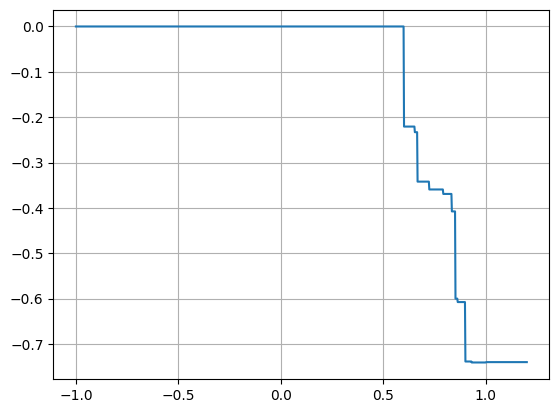

In [81]:
length = 1000

thresh_values = np.linspace(-1, 1.2, length)[..., None]
f1_values = np.zeros(length)

for idx, thresh in enumerate(thresh_values):
    f1_values[idx] = calculat_f1(thresh)

plt.plot(thresh_values, f1_values)
plt.grid(True)

In [82]:
x0 = np.array([0.5])

res = minimize(calculat_f1, x0=x0, method='Powell')
threshold = res.x[0]
print("Оптимальный порог:", threshold)

Оптимальный порог: 3.087928961545842


In [83]:
df['SugenoIntegral'].describe()

count    27901.000000
mean         0.831631
std          0.104785
min          0.600000
25%          0.833333
50%          0.850000
75%          0.900000
max          1.000000
Name: SugenoIntegral, dtype: float64

In [84]:
y_train.describe()

count    19530.000000
mean         0.587302
std          0.492332
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Depression, dtype: float64

In [85]:
(df['SugenoIntegral'] > threshold).astype(np.int32).describe()

count    27901.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: SugenoIntegral, dtype: float64

In [86]:
y_pred_train = (X_train['SugenoIntegral'] < threshold).astype(np.int32)
y_pred_test = (X_test['SugenoIntegral'] < threshold).astype(np.int32)

In [87]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      8060
           1       0.59      1.00      0.74     11470

    accuracy                           0.59     19530
   macro avg       0.29      0.50      0.37     19530
weighted avg       0.34      0.59      0.43     19530



c:\Users\Viktor\Documents\IT\DecisionTheory\FuzzyLogic\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Viktor\Documents\IT\DecisionTheory\FuzzyLogic\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Viktor\Documents\IT\DecisionTheory\FuzzyLogic\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [88]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3505
           1       0.58      1.00      0.74      4866

    accuracy                           0.58      8371
   macro avg       0.29      0.50      0.37      8371
weighted avg       0.34      0.58      0.43      8371



c:\Users\Viktor\Documents\IT\DecisionTheory\FuzzyLogic\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Viktor\Documents\IT\DecisionTheory\FuzzyLogic\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Viktor\Documents\IT\DecisionTheory\FuzzyLogic\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa